In [1]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to c:\users\sofia\appdata\local\temp\pip-req-build-32es4cfl
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git 'C:\Users\sofia\AppData\Local\Temp\pip-req-build-32es4cfl'


## Imports & plotting function

In [2]:
import os, sys
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt

import text_flappy_bird_gym

In [3]:
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    import matplotlib
    
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    Z = np.apply_along_axis(lambda _: V.get((_[0], _[1]), 0), 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=min(Z.flatten()), vmax=max(Z.flatten()))
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z, title=title)

## Exploring Environment 

In [4]:
# initiate environment
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

# iterate
while True:

    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    print(obs, info, action, reward)
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[      @             ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=1)
(12, 1) {'score': 0, 'player': [6, 7], 'distance': 12.041594578792296} 0 1
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From P

## Define Agents 

In [5]:
# Monte Carlo Agent
class MonteCarloAgent:
    def __init__(self, env, epsilon=0.1, gamma=0.99, alpha=0.1):
        self.env = env
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.Q = {}  # Key: (state, action), Value: Q-value
        self.returns = {}  # Key: (state, action), Value: list of returns
    
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            q_values = [self.Q.get((state, a), 0) for a in [0, 1]]
            return np.argmax(q_values)
    
    def train(self, episodes=1000, seed=None):
        if seed is not None:
            np.random.seed(seed)
        rewards = []
        for _ in range(episodes):
            episode = []
            if self.env.spec.id == 'TextFlappyBird-v0':
                state = self.env.reset()[0]
            else:
                state = self.env.reset()
            state = tuple(state) # Convert state to tuple for hashing
            done = False
            while not done:
                action = self.get_action(state)
                next_state, reward, done = self.env.step(action)[:3]
                next_state = tuple(next_state)
                episode.append((state, action, reward))
                state = next_state
            # Update Q-values using Monte Carlo
            G = 0
            for t in reversed(range(len(episode))):
                state, action, reward = episode[t]
                G = self.gamma * G + reward
                if (state, action) not in [(x[0], x[1]) for x in episode[:t]]:
                    old_Q = self.Q.get((state, action), 0)
                    self.Q[(state, action)] = old_Q + self.alpha * (G - old_Q)
            rewards.append(G)
        return rewards

# Sarsa(λ) Agent
class SarsaLambdaAgent:
    def __init__(self, env, lambda_=0.1, epsilon=0.1, gamma=0.99, alpha=0.1):
        self.env = env
        self.lambda_ = lambda_
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.Q = {}
        self.e = {}  # Eligibility traces
    
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        else:
            q_values = [self.Q.get((state, a), 0) for a in [0, 1]]
            return np.argmax(q_values)
    
    def train(self, episodes=1000, seed=None):
        if seed is not None:
            np.random.seed(seed)
        rewards = []
        for _ in range(episodes):
            self.e = {}  # Reset traces
            if self.env.spec.id == 'TextFlappyBird-v0':
                state = self.env.reset()[0]
            else:
                state = self.env.reset()
            state = tuple(state)  
            action = self.get_action(state)
            done = False
            total_reward = 0
            while not done:
                next_state, reward, done = self.env.step(action)[:3]
                next_state = tuple(next_state)
                next_action = self.get_action(next_state)
                delta = reward + self.gamma * self.Q.get((next_state, next_action), 0) - self.Q.get((state, action), 0)
                # Update eligibility traces
                self.e[(state, action)] = self.e.get((state, action), 0) + 1
                for sa in self.e:
                    self.Q[sa] = self.Q.get(sa, 0) + self.alpha * delta * self.e[sa]
                    self.e[sa] *= self.gamma * self.lambda_
                total_reward += reward
                state, action = next_state, next_action
            rewards.append(total_reward)
        return rewards

## Train in simple Environment 

In [6]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)

Iteration 1/5...
Monte Carlo Agent Time: 73.30 seconds
Sarsa Agent Time: 42.58 seconds


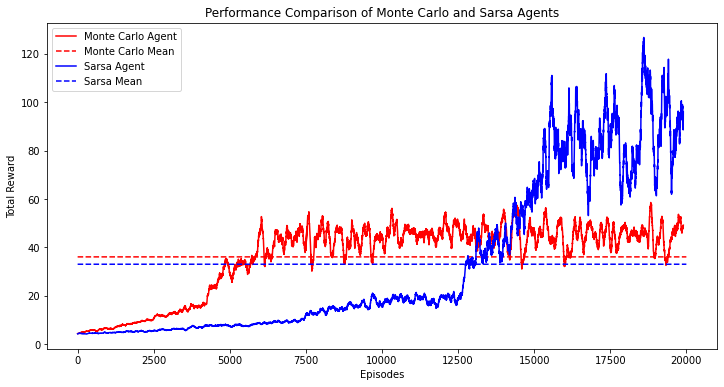

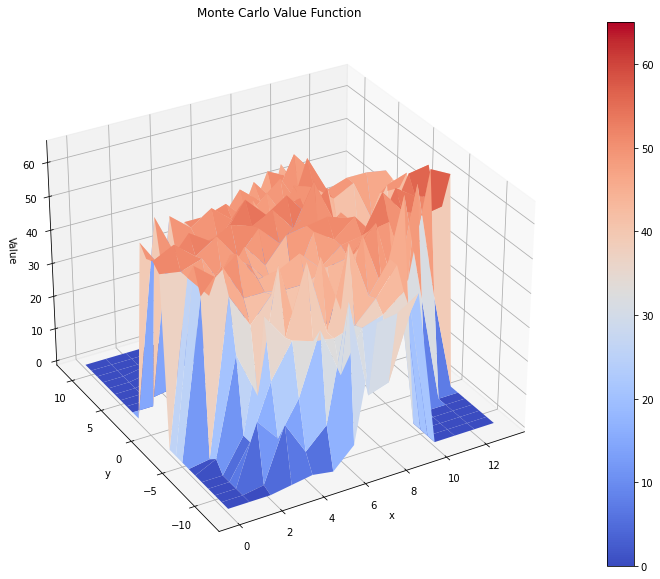

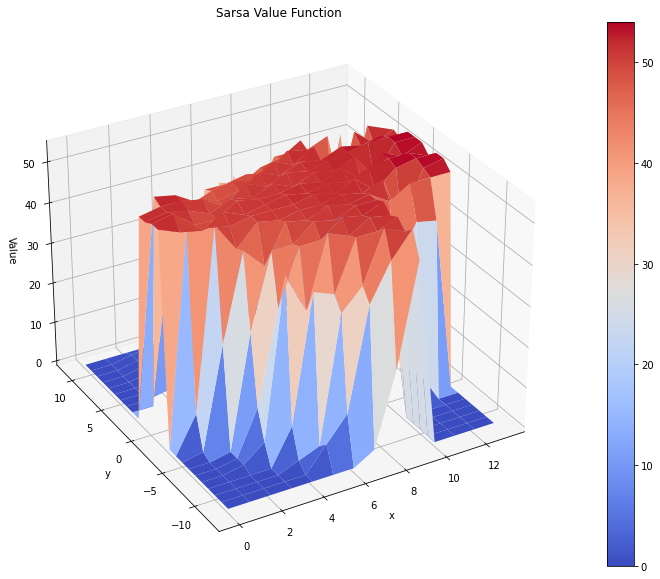

Iteration 2/5...
Monte Carlo Agent Time: 32.88 seconds
Sarsa Agent Time: 19.85 seconds


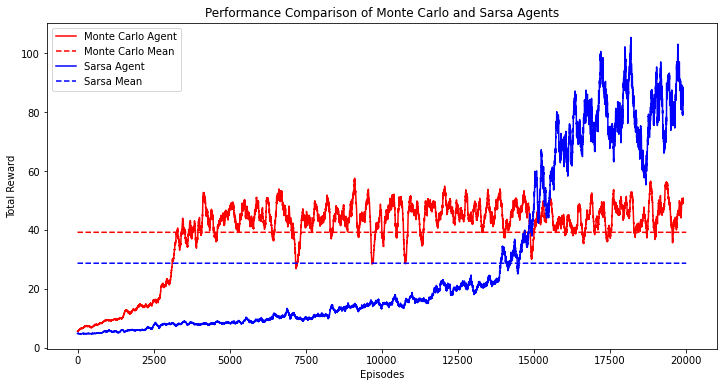

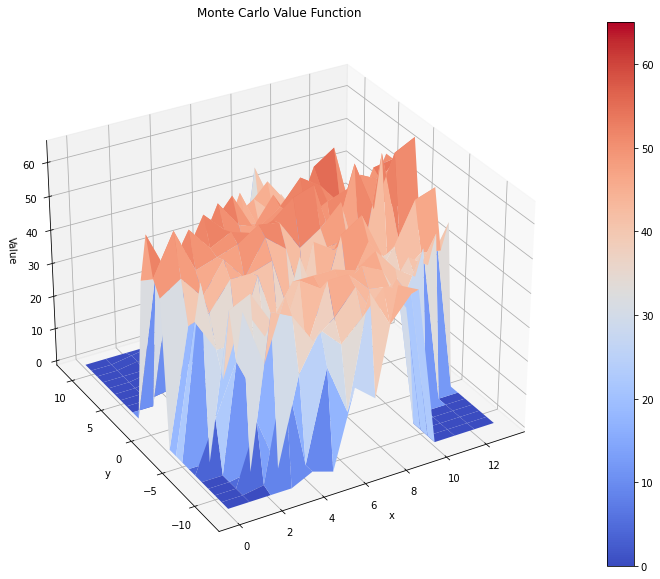

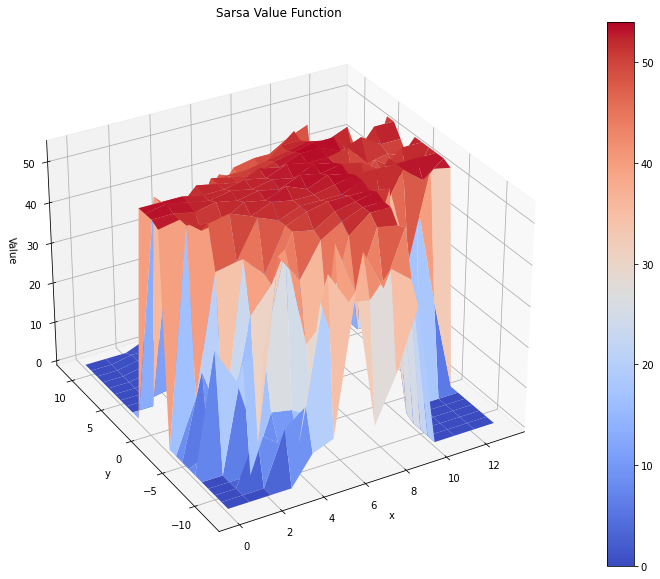

Iteration 3/5...
Monte Carlo Agent Time: 27.86 seconds
Sarsa Agent Time: 12.49 seconds


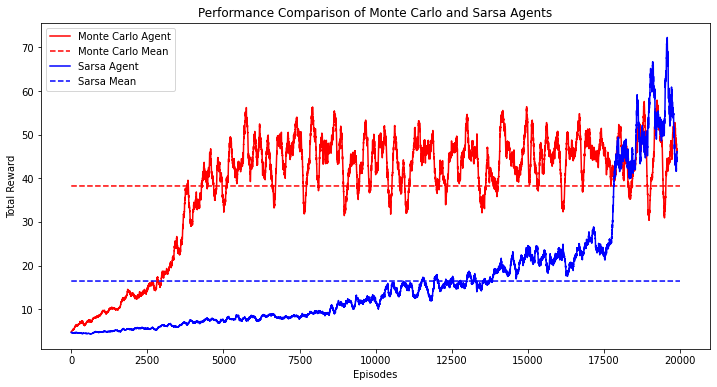

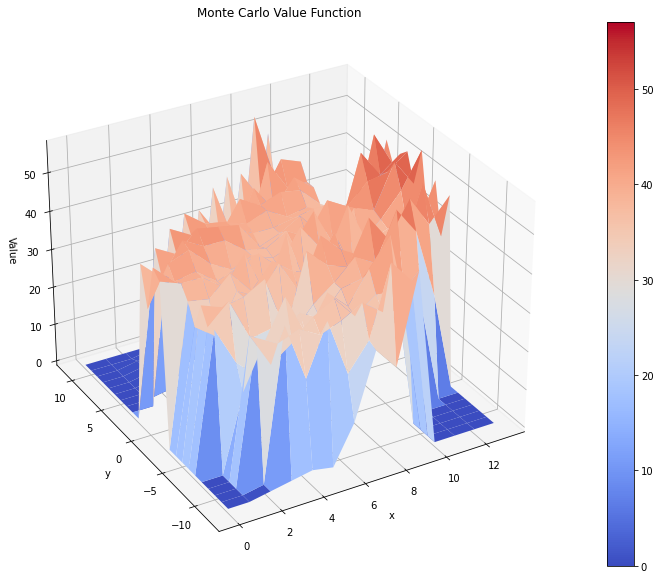

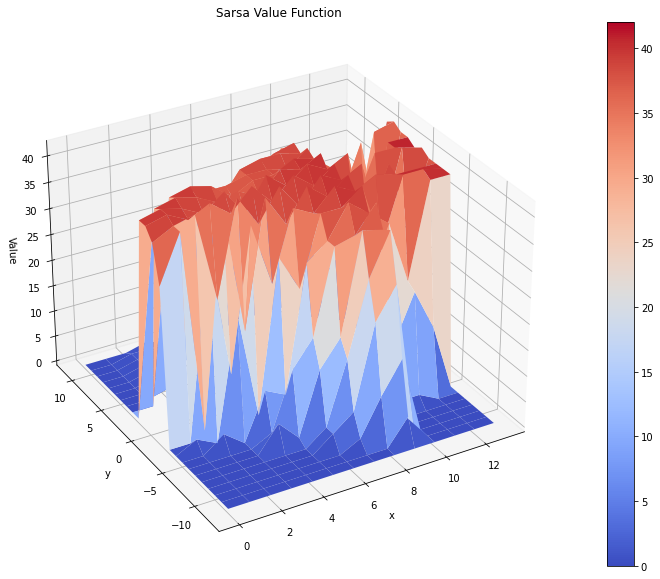

Iteration 4/5...
Monte Carlo Agent Time: 34.90 seconds
Sarsa Agent Time: 41.53 seconds


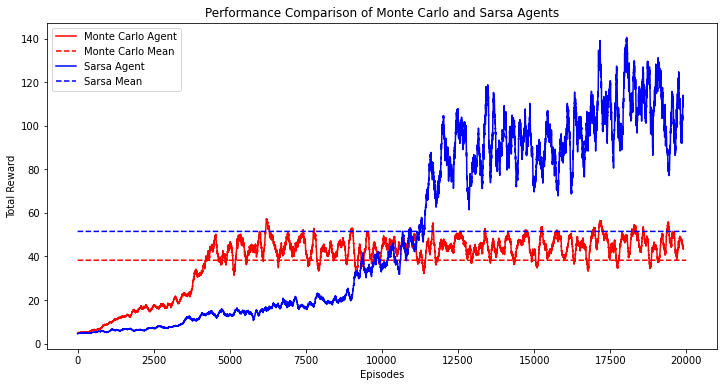

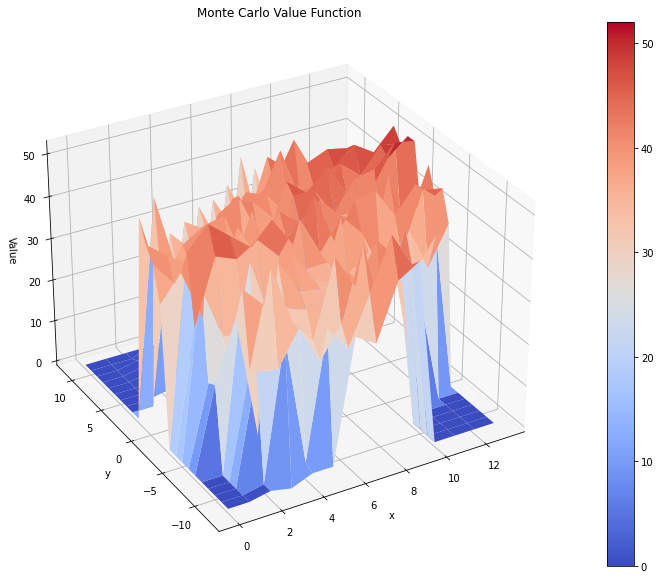

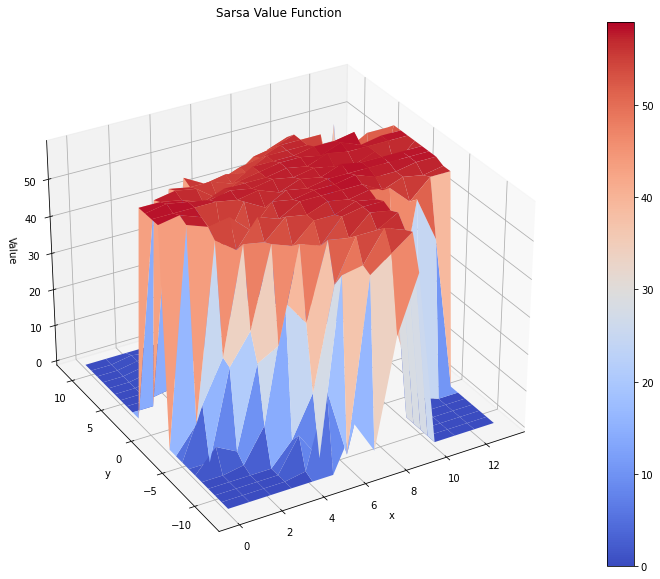

Iteration 5/5...
Monte Carlo Agent Time: 37.80 seconds
Sarsa Agent Time: 17.33 seconds


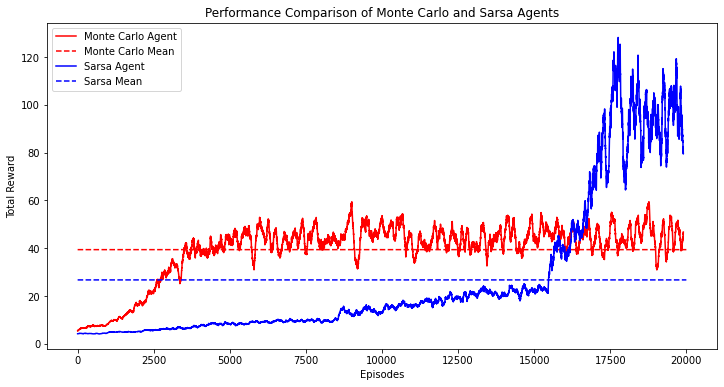

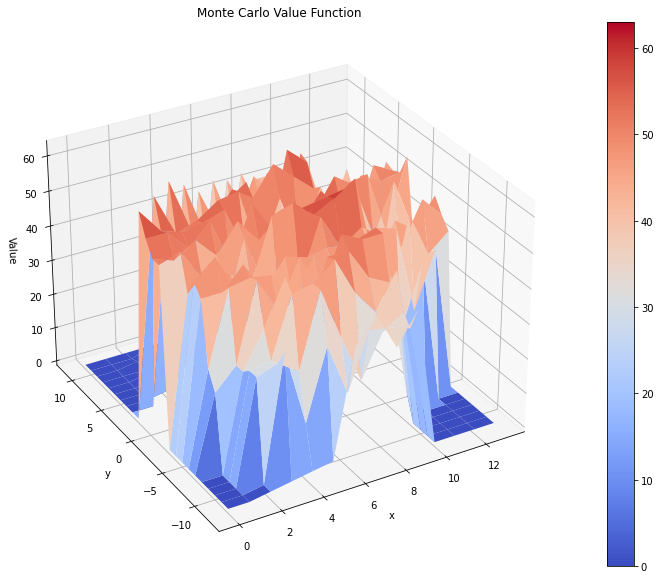

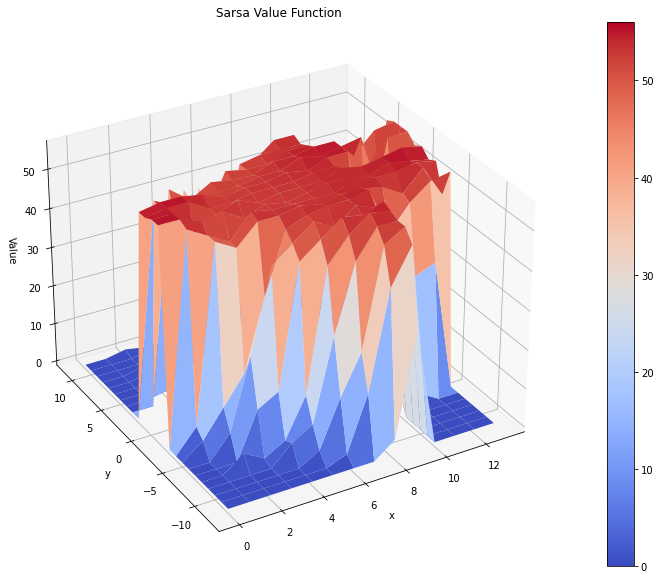

In [7]:
episodes = 20000
iterations = 5

for i in range(iterations):
    env.reset()

    print(f"Iteration {i+1}/{iterations}...")
    
    # count time 
    start_time = time.time()

    mc_agent = MonteCarloAgent(env)
    mc_rewards = mc_agent.train(episodes=episodes)
    end_time_mc = time.time()

    sarsa_agent = SarsaLambdaAgent(env)
    sarsa_rewards = sarsa_agent.train(episodes= episodes)
    end_time_sarsa = time.time()

    elapsed_time_mc = end_time_mc - start_time
    elapsed_time_sarsa = end_time_sarsa - end_time_mc

    print(f"Monte Carlo Agent Time: {elapsed_time_mc:.2f} seconds")
    print(f"Sarsa Agent Time: {elapsed_time_sarsa:.2f} seconds")

    # Compare the performance of the two agents
    plt.figure(figsize=(12, 6))
    plt.plot([np.mean(mc_rewards[i:i+100]) for i in range(len(mc_rewards)-100)],'r', label='Monte Carlo Agent')
    plt.plot([np.mean(mc_rewards)]*episodes, 'r--', label='Monte Carlo Mean')
    plt.plot([np.mean(sarsa_rewards[i:i+100]) for i in range(len(sarsa_rewards)-100)], 'b', label='Sarsa Agent')
    plt.plot([np.mean(sarsa_rewards)]*episodes, 'b--', label='Sarsa Mean')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Performance Comparison of Monte Carlo and Sarsa Agents')
    plt.legend()
    plt.show()

    # Compare Value functions
    def value_function(Q):
        V = {}
        for (state, action), value in Q.items():
            if state not in V:
                V[state] = 0
            V[state] = max(V[state],value)
        return V

    mc_v = value_function(mc_agent.Q)
    sarsa_v = value_function(sarsa_agent.Q)

    plot_value_function(mc_v, title='Monte Carlo Value Function')
    plot_value_function(sarsa_v, title='Sarsa Value Function')


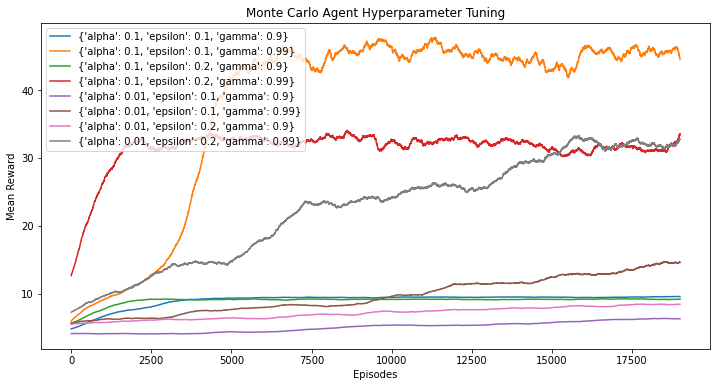

In [8]:
# GridSearch for hyperparameters for Monte Carlo Agent
from sklearn.model_selection import ParameterGrid

# Define the parameter grid
param_mc = {
    'epsilon': [0.1, 0.2],
    'gamma': [0.9, 0.99],
    'alpha': [0.1, 0.01]
}

# Create a list of all parameter combinations
param_grid_mc = ParameterGrid(param_mc)
results_mc = []

for params in param_grid_mc:
    agent = MonteCarloAgent(env, **params)
    rewards = agent.train(episodes=episodes)
    mean_reward = [np.mean(rewards[i:i+1000]) for i in range(len(rewards)-1000)]
    results_mc.append((params, mean_reward))

# Plot the results
plt.figure(figsize=(12, 6))
plt.title('Monte Carlo Agent Hyperparameter Tuning')
for params, mean_reward in results_mc:  
    plt.plot(mean_reward, label=str(params))
plt.xlabel('Episodes')
plt.ylabel('Mean Reward')
plt.legend()
plt.show()

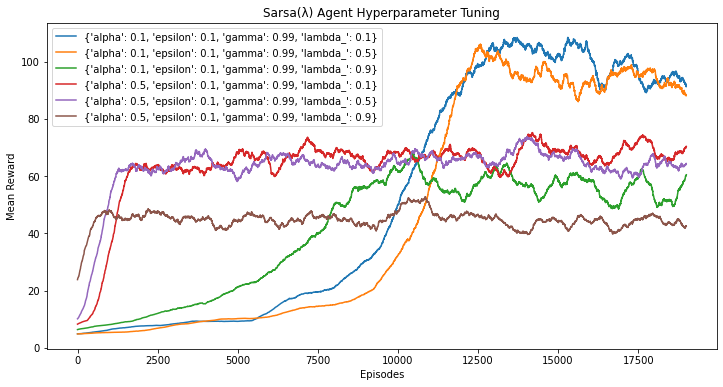

In [9]:
# GridSearch for hyperparameters for Sarsa(λ) agent
params_sarsa = {
    'lambda_': [0.1, 0.5, 0.9],
    'epsilon': [0.1],
    'gamma': [0.99],
    'alpha': [0.1, 0.5]
}

# Create a grid of hyperparameters
param_grid_sarsa = ParameterGrid(params_sarsa)
results = []

for params in param_grid_sarsa:
    agent = SarsaLambdaAgent(env, **params)
    rewards = agent.train(episodes=episodes)
    mean_reward = [np.mean(rewards[i:i+1000]) for i in range(len(rewards)-1000)]
    results.append((params, mean_reward))

# Plot the results
plt.figure(figsize=(12, 6))
plt.title('Sarsa(λ) Agent Hyperparameter Tuning')
for params, mean_reward in results:
    plt.plot(mean_reward, label=str(params))
plt.xlabel('Episodes')
plt.ylabel('Mean Reward')
plt.legend()
plt.show()

## Different Environment 

### Different implementation

In [10]:
# https://github.com/Talendar/flappy-bird-gym

In [11]:
# !pip install flappy-bird-gym

In [ ]:
import flappy_bird_gym

env1 = flappy_bird_gym.make('FlappyBird-v0')

In [13]:
# Example of state
obs = env1.reset()
print(obs)

[1.65625   0.0234375]


c:\Users\sofia\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
c:\Users\sofia\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
c:\Users\sofia\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(


#### Using trained agents 

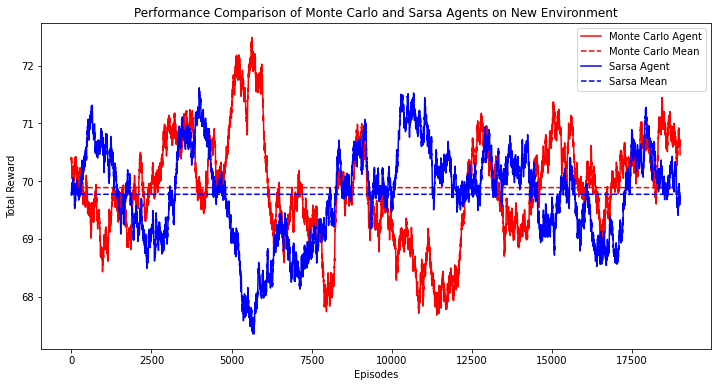

In [19]:
mc_agent = MonteCarloAgent(env)
mc_rewards = mc_agent.train(episodes=20000)

sarsa_agent = SarsaLambdaAgent(env)
sarsa_rewards = sarsa_agent.train(episodes=20000)


def run_episode(agent, env, render=False):
    state = env.reset()
    state = tuple(state)  
    done = False
    total_reward = 0
    while not done:
        if render:
            env.render()
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = tuple(next_state)
        total_reward += reward
        state = next_state
    return total_reward


EPISODES = 20000

rewards = {"mc":[0]*EPISODES, "sarsa":[0]*EPISODES}

for i in range(EPISODES):
    for name, agent in zip(["mc", "sarsa"], [mc_agent, sarsa_agent]):
        rewards[name][i] = run_episode(agent, env1, render=False)
        

plt.figure(figsize=(12, 6))
plt.plot([np.mean(rewards["mc"][i:i+1000]) for i in range(EPISODES-1000)], 'r', label='Monte Carlo Agent')
plt.plot([np.mean(rewards["mc"])]*(EPISODES-1000), 'r--', label='Monte Carlo Mean')
plt.plot([np.mean(rewards["sarsa"][i:i+1000]) for i in range(EPISODES-1000)], 'b', label='Sarsa Agent')
plt.plot([np.mean(rewards["sarsa"])]*(EPISODES-1000), 'b--', label='Sarsa Mean')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Performance Comparison of Monte Carlo and Sarsa Agents on New Environment')
plt.legend()

#### Retrain the agents 

Iteration 1/5...
Monte Carlo Agent Time: 111.43 seconds
Sarsa Agent Time: 171.28 seconds


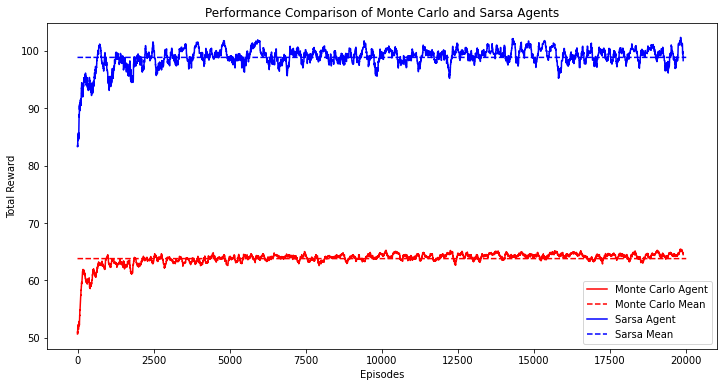

Iteration 2/5...
Monte Carlo Agent Time: 123.74 seconds
Sarsa Agent Time: 237.57 seconds


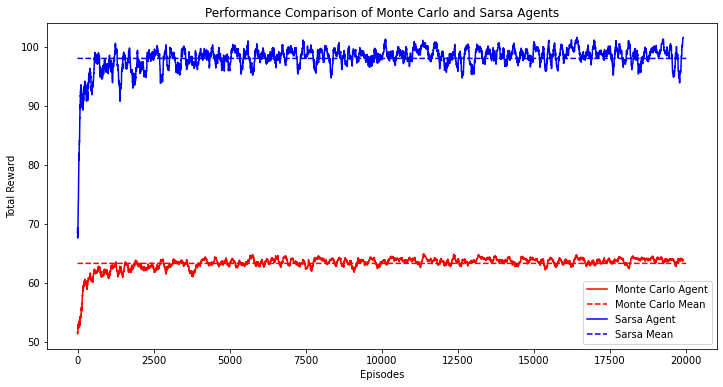

Iteration 3/5...
Monte Carlo Agent Time: 60.08 seconds
Sarsa Agent Time: 195.78 seconds


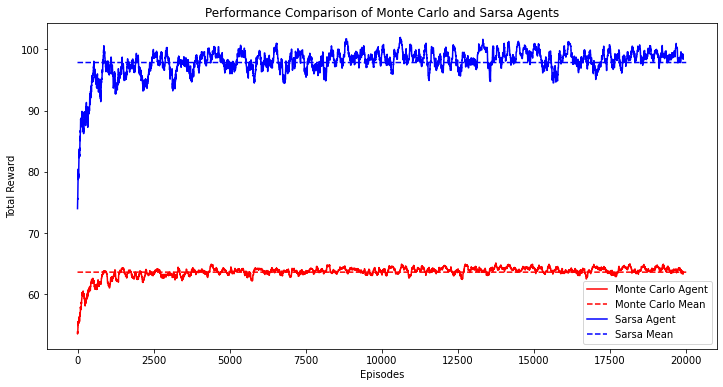

Iteration 4/5...
Monte Carlo Agent Time: 80.93 seconds
Sarsa Agent Time: 304.14 seconds


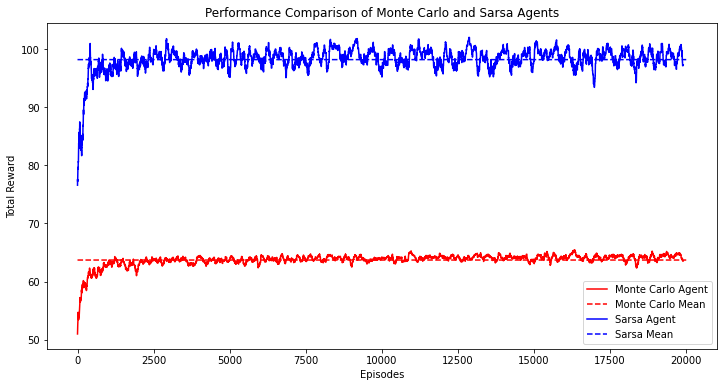

Iteration 5/5...
Monte Carlo Agent Time: 83.27 seconds
Sarsa Agent Time: 152.16 seconds


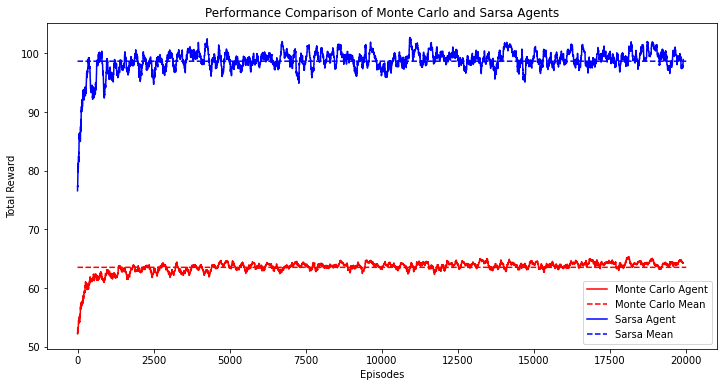

In [18]:
iterations = 5

for i in range(iterations):
    env1.reset()
    
    print(f"Iteration {i+1}/{iterations}...")
    
    # count time
    start_time = time.time()

    mc_agent = MonteCarloAgent(env1)
    mc_rewards = mc_agent.train(episodes=20000)
    end_time_mc = time.time()

    sarsa_agent = SarsaLambdaAgent(env1)
    sarsa_rewards = sarsa_agent.train(episodes=20000)
    end_time_sarsa = time.time()

    elapsed_time_mc = end_time_mc - start_time
    elapsed_time_sarsa = end_time_sarsa - end_time_mc

    print(f"Monte Carlo Agent Time: {elapsed_time_mc:.2f} seconds")
    print(f"Sarsa Agent Time: {elapsed_time_sarsa:.2f} seconds")

    # Compare the performance of the two agents
    plt.figure(figsize=(12, 6))
    plt.plot([np.mean(mc_rewards[i:i+100]) for i in range(len(mc_rewards)-100)],'r', label='Monte Carlo Agent')
    plt.plot([np.mean(mc_rewards)]*episodes, 'r--', label='Monte Carlo Mean')
    plt.plot([np.mean(sarsa_rewards[i:i+100]) for i in range(len(sarsa_rewards)-100)], 'b', label='Sarsa Agent')
    plt.plot([np.mean(sarsa_rewards)]*episodes, 'b--', label='Sarsa Mean')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Performance Comparison of Monte Carlo and Sarsa Agents')
    plt.legend()
    plt.show()

### Different environment configuration

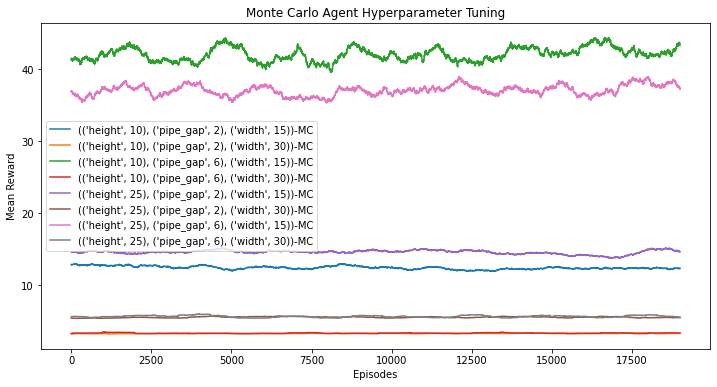

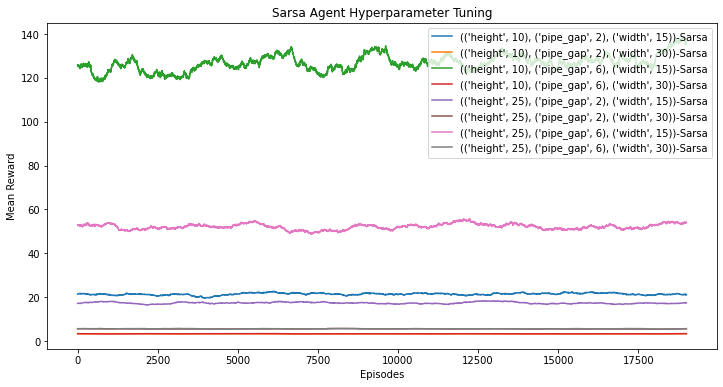

In [28]:
def run_episode(agent, env, render=False):
    state = env.reset()[0]
    done = False
    total_reward = 0
    while not done:
        if render:
            env.render()
        action = agent.get_action(state)
        next_state, reward, done, _, _ = env.step(action)
        total_reward += reward
        state = next_state
    return total_reward

param_grid = {
    'height': [10, 25],
    'width': [15, 30],
    'pipe_gap': [2, 6]
}

# Create a list of all parameter combinations
param_grid_list = ParameterGrid(param_grid)
results = {}
for params in param_grid_list:

    env1 = gym.make('TextFlappyBird-v0', **params)

    mc_rewards = []
    sarsa_rewards = []
    for ep in range(EPISODES):
        mc_rewards.append(run_episode(mc_agent, env1, render=False))
        sarsa_rewards.append(run_episode(sarsa_agent, env1, render=False))

    # Calculate mean rewards
    mean_mc_reward = [np.mean(mc_rewards[i:i+1000]) for i in range(len(mc_rewards)-1000)]
    mean_sarsa_reward = [np.mean(sarsa_rewards[i:i+1000]) for i in range(len(sarsa_rewards)-1000)]

    # Store results
    results[tuple(params.items())] = {
        'mc_mean_reward': mean_mc_reward,
        'sarsa_mean_reward': mean_sarsa_reward
    }

# Plot the results
plt.figure(figsize=(12, 6))
for params, rewards in results.items():
    mean_mc_reward = rewards['mc_mean_reward']
    plt.plot(mean_mc_reward, label=str(params) +'-MC')
plt.xlabel('Episodes')
plt.ylabel('Mean Reward')
plt.title('Monte Carlo Agent Hyperparameter Tuning')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for params, rewards in results.items():
    mean_sarsa_reward = rewards['sarsa_mean_reward']
    plt.plot(mean_sarsa_reward, label=str(params) +'-Sarsa')
plt.xlabel('Episodes')
plt.ylabel('Mean Reward')
plt.title('Sarsa Agent Hyperparameter Tuning')
plt.legend()
plt.show()